In [1]:
from collections import defaultdict
from functools import lru_cache
from pathlib import Path

import aquarel
import ir_datasets
import ir_measures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyterrier as pt
from ir_datasets import docs_parent_id
from tqdm import tqdm

import sys

if ".." not in sys.path:
    sys.path.append("..")

DASHED_DATASET_MAP = {
    dataset.replace("/", "-"): dataset for dataset in ir_datasets.registry._registered
}

def get_parent(dataset_id):
    parent_id = docs_parent_id(dataset_id)
    if "medline" in parent_id:
        return parent_id.replace("/2004", "").replace("/2017", "")
    return parent_id 

In [2]:
theme = aquarel.Theme.from_file("./aquarel-theme.json")
theme.apply()
markers = ["o", "X", "s", "v", "P", "*", "D"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Helper Functions

In [3]:
@lru_cache(maxsize=2_048)
def load_run(run_file):
    run = pd.read_csv(
        run_file,
        sep=r"\s+",
        header=None,
        names=["query_id", "Q0", "doc_id", "rank", "score", "run_name"],
    )
    run = run.sort_values(["query_id", "score"], ascending=[True, False])
    run["rank"] = run.groupby("query_id")["score"].rank(ascending=False, method="first")

    run_name = run_file.parent.name

    if ("chatnoir" in run_name or "colbert" in run_name or "bm25" in run_name) and "monoelectra" not in run_name:
        if "colbert" in run_name:
            first_stage = "colbert"
        else:
            first_stage = "bm25"
        run_name = "first_stage"
        dataset_name = run_file.name.split(".")[0]
    else:
        split = run_file.name.split(".")[0].split("_")
        if len(split) == 2:
            first_stage, dataset_name = split
        else:
            first_stage = "bm25"
            dataset_name = split[0]
        if "tirex" in first_stage:
            first_stage = "bm25"
    dataset_id = DASHED_DATASET_MAP[dataset_name]

    config = {}
    config["run_name"] = run_name
    config["dataset"] = dataset_id
    config["first_stage"] = first_stage

    run = run.astype({"query_id": str, "doc_id": str})
    return run, config


@lru_cache
def load_qrels(dataset):
    dataset = ir_datasets.load(dataset)
    qrels_df = pd.DataFrame(dataset.qrels_iter())
    return qrels_df


@lru_cache
def load_topics(dataset):
    dataset = ir_datasets.load(dataset)
    topics_df = pd.DataFrame(dataset.queries_iter())
    return topics_df

In [4]:
def evaluate_runs(
    per_dataset_runs, baseline, ir_measures_metrics, models, datasets, group_by_base=False, compute_means=False
):
    _results = []
    filtered_per_dataset_runs = defaultdict(dict)
    for dataset in datasets:
        for run_name, run in per_dataset_runs[dataset].items():
            if run_name in models:
                filtered_per_dataset_runs[dataset][run_name] = run
    pg = tqdm(datasets)
    topics = []
    qrels = []
    runs = defaultdict(list)
    for idx, (first_stage, dataset) in enumerate(pg):
        pg.set_description(f"{first_stage}-{dataset}")
        runs_dict = filtered_per_dataset_runs.get((first_stage, dataset))
        if runs_dict is None:
            raise ValueError(f"Run not found for {first_stage}-{dataset}")
        qrels.append(
            load_qrels(dataset).rename(
                columns={"query_id": "qid", "doc_id": "docno", "relevance": "label", "subtopic_id": "iteration"}
            )
        )
        topics.append(load_topics(dataset).rename(columns={"query_id": "qid"}))
        for run_name, run in runs_dict.items():
            runs[run_name].append(run.rename(columns={"query_id": "qid", "doc_id": "docno"}).astype({"docno": str}))

        base = get_parent(dataset)
        next_base = get_parent(datasets[idx + 1][1]) if idx + 1 < len(datasets) else None
        if not group_by_base or base != next_base:
            run_names = list(runs.keys())
            run_dfs = [pd.concat(runs[run_name]) for run_name in run_names]
            try:
                base_index = run_names.index(baseline)
                kwargs = {"baseline": base_index, "correction": "holm"}
            except ValueError:
                kwargs = {}

            # filter empty runs
            all_topics = pd.concat(topics)
            run_topics = [set(df["qid"].unique()) for df in run_dfs]
            topics_union = set.intersection(*run_topics)
            all_topics = all_topics.loc[all_topics["qid"].isin(topics_union)]
            all_qrels = pd.concat(qrels)
            all_qrels = all_qrels.loc[all_qrels["qid"].isin(topics_union)]
            run_dfs = [df.loc[df["qid"].isin(topics_union)].reset_index(drop=True) for df in run_dfs]

            result = pt.Experiment(run_dfs, all_topics, all_qrels, ir_measures_metrics, names=run_names, **kwargs)
            topics = []
            qrels = []
            runs = defaultdict(list)
            result["first_stage"] = first_stage
            if group_by_base:
                result["dataset"] = base
            else:
                result["dataset"] = dataset
            _results.append(result)

    results = pd.concat(_results)

    if compute_means:

        def gmean(x):
            return np.exp(np.log(x.prod()) / x.notna().sum())

        str_metrics = [str(m) for m in ir_measures_metrics]

        arithmetic_mean = results.groupby("name")[str_metrics].mean().reset_index()
        arithmetic_mean["dataset"] = "arithmetic-mean"
        geometric_mean = results.groupby("name")[str_metrics].agg(gmean).reset_index()
        geometric_mean["dataset"] = "geometric-mean"

        summary = pd.concat([arithmetic_mean, geometric_mean])
        results = pd.concat([results, summary])

    return results

In [5]:
def format_columns(series, round_to=3):
    drop_rows = ["cohere-embed-english-v3", "bge-base-en-v1"]
    rounded = series.round(round_to)
    values = sorted(set(rounded.drop(drop_rows, axis=0, errors="ignore").dropna()), reverse=True)
    best = values[0]
    second_best = values[1]
    out_values = []
    for val in rounded:
        if pd.isna(val):
            out_val = "--"
        else:
            out_val = f"{val:.{round_to}f}"
        if val == best:
            out_val = "\\textbf{" + out_val + "}"
        if val == second_best:
            out_val = "\\underline{" + out_val + "}"
        out_values.append(out_val)
    out = pd.Series(out_values, index=series.index)
    return out

## Load runs

In [6]:
EXPERIMENTS_DIR = Path.cwd().parent / "data" / "experiments"

per_dataset_runs = defaultdict(dict)

run_files = list(EXPERIMENTS_DIR.glob("*/*.run"))

models = set()
datasets = set()
pg = tqdm(run_files)
for run_file in pg:
    pg.set_description(str(run_file.relative_to(EXPERIMENTS_DIR)))
    run, config = load_run(run_file)
    models.add(config["run_name"])
    datasets.add((config["first_stage"], config["dataset"]))
    per_dataset_runs[(config["first_stage"], config["dataset"])][config["run_name"]] = run

# filter top-100 from tirex runs since tirex re-ranked top 1000
pg = tqdm(per_dataset_runs)
for first_stage, dataset in pg:
    if first_stage != "bm25":
        continue
    pg.set_description(f"{first_stage}-{dataset}")
    runs = per_dataset_runs[(first_stage, dataset)]
    run_names = list(runs.keys())
    first_stage_run = runs["first_stage"]
    run_names.remove("first_stage")
    first_stage_top_100 = first_stage_run.loc[first_stage_run["rank"] <= 100]
    query_doc_id_pairs = first_stage_top_100.set_index(["query_id", "doc_id"]).index
    for run_name in run_names:
        run = runs[run_name]
        run = run.set_index(["query_id", "doc_id"])
        run = run.reindex(query_doc_id_pairs).dropna()
        run = run.reset_index()
        run["rank"] = run.groupby("query_id")["score"].rank(ascending=False, method="first")
        run = run.sort_values(["query_id", "rank"])
        per_dataset_runs[(first_stage, dataset)][run_name] = run
    

models, datasets

monoelectra-base-dual-rankgpt/tirex-rerank_nfcorpus-test.run:   0%|          | 0/668 [00:00<?, ?it/s]                 

monoelectra-base-single-twolar/tirex-rerank_gov2-trec-tb-2005.run: 100%|██████████| 668/668 [00:16<00:00, 39.95it/s]                                       
bm25-gov2/trec-tb-2005: 100%|██████████| 33/33 [00:09<00:00,  3.31it/s]                   


({'first_stage',
  'monoelectra-base',
  'monoelectra-base-dual-rank-distillm-bm25',
  'monoelectra-base-dual-rank-distillm-colbert',
  'monoelectra-base-dual-rank-distillm-colbert-10k-10',
  'monoelectra-base-dual-rank-distillm-colbert-10k-20',
  'monoelectra-base-dual-rank-distillm-colbert-10k-50',
  'monoelectra-base-dual-rank-distillm-colbert-1k-100',
  'monoelectra-base-dual-rank-distillm-colbert-2k-100',
  'monoelectra-base-dual-rank-distillm-colbert-5k-100',
  'monoelectra-base-dual-rank-distillm-colbert-adrmse',
  'monoelectra-base-dual-rankgpt',
  'monoelectra-base-dual-twolar',
  'monoelectra-base-single-rank-distillm-bm25',
  'monoelectra-base-single-rank-distillm-colbert',
  'monoelectra-base-single-rankgpt',
  'monoelectra-base-single-twolar',
  'monoelectra-large',
  'monot5-3b',
  'rankgpt-4',
  'rankt5-3b',
  'rankzephyr'},
 {('bm25', 'antique/test'),
  ('bm25', 'argsme/2020-04-01/touche-2020-task-1'),
  ('bm25', 'argsme/2020-04-01/touche-2021-task-1'),
  ('bm25', 'clue

## Evaluate TREC DL

In [7]:
trec_dl_models = [
    "first_stage",
    "rankgpt-4",
    "rankzephyr",
    "monot5-3b",
    "rankt5-3b",
    "monoelectra-base",
    "monoelectra-base-single-rankgpt",
    "monoelectra-base-single-twolar",
    "monoelectra-base-single-rank-distillm-bm25",
    "monoelectra-base-single-rank-distillm-colbert",
    "monoelectra-base-dual-rankgpt",
    "monoelectra-base-dual-twolar",
    "monoelectra-base-dual-rank-distillm-bm25",
    "monoelectra-base-dual-rank-distillm-colbert",
    "monoelectra-large",
]

trec_dl_datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
    ("colbert", "msmarco-passage/trec-dl-2019/judged"),
    ("colbert", "msmarco-passage/trec-dl-2020/judged"),
]

trec_dl_results = evaluate_runs(
    per_dataset_runs,
    "monoelectra-base-dual-rank-distillm-colbert",
    [ir_measures.nDCG(cutoff=10)],
    trec_dl_models,
    trec_dl_datasets,
)

colbert-msmarco-passage/trec-dl-2020/judged: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


In [8]:
index = "name"
columns = ["first_stage", "dataset"]
values = ["nDCG@10"]

pd.set_option("display.max_columns", None)

table = (
    trec_dl_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .droplevel(0, axis=1)
)
sig = (
    trec_dl_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .droplevel(0, axis=1)
)
table = (table + sig)
table = table.loc[trec_dl_models]
table

first_stage                                                                  bm25  \
dataset                                       msmarco-passage/trec-dl-2019/judged   
name                                                                                
first_stage                                                                0.480*   
rankgpt-4                                                                   0.713   
rankzephyr                                                                  0.719   
monot5-3b                                                                   0.705   
rankt5-3b                                                                   0.710   
monoelectra-base                                                            0.687   
monoelectra-base-single-rankgpt                                             0.696   
monoelectra-base-single-twolar                                              0.693   
monoelectra-base-single-rank-distillm-bm25                                 0.644*   
monoelectra-base-single-rank-distillm-colbert                               0.709   
monoelectra-base-dual-rankgpt                                              0.664*   
monoelectra-base-dual-twolar                                                0.715   
monoelectra-base-dual-rank-distillm-bm25                                   0.672*   
monoelectra-base-dual-rank-distillm-colbert                     \underline{0.720}   
monoelectra-large                                                  \textbf{0.733}   

first_stage                                                                        \
dataset                                       msmarco-passage/trec-dl-2020/judged   
name                                                                                
first_stage                                                                0.494*   
rankgpt-4                                                                   0.713   
rankzephyr                                                      \underline{0.720}   
monot5-3b                                                                   0.715   
rankt5-3b                                                                   0.711   
monoelectra-base                                                            0.698   
monoelectra-base-single-rankgpt                                            0.666*   
monoelectra-base-single-twolar                                             0.669*   
monoelectra-base-single-rank-distillm-bm25                                 0.622*   
monoelectra-base-single-rank-distillm-colbert                               0.704   
monoelectra-base-dual-rankgpt                                              0.634*   
monoelectra-base-dual-twolar                                                0.706   
monoelectra-base-dual-rank-distillm-bm25                                   0.638*   
monoelectra-base-dual-rank-distillm-colbert                                 0.711   
monoelectra-large                                                  \textbf{0.727}   

first_stage                                                               colbert  \
dataset                                       msmarco-passage/trec-dl-2019/judged   
name                                                                                
first_stage                                                                 0.732   
rankgpt-4                                                                   0.766   
rankzephyr                                                                  0.749   
monot5-3b                                                                   0.745   
rankt5-3b                                                                   0.752   
monoelectra-base                                                            0.739   
monoelectra-base-single-rankgpt                                            0.690*   
monoelectra-base-single-twolar                                              0.754   
mon

## Evaluate TIREx

In [9]:
tirex_models = [
    "first_stage",
    "rankzephyr",
    "monot5-3b",
    "rankt5-3b",
    "monoelectra-base",
    "monoelectra-base-dual-twolar",
    "monoelectra-base-dual-rank-distillm-colbert",
    "monoelectra-large",
]

tirex_datasets = [
    ("bm25", "antique/test"),
    ("bm25", "argsme/2020-04-01/touche-2020-task-1"),
    ("bm25", "argsme/2020-04-01/touche-2021-task-1"),
    ("bm25", "clueweb09/en/trec-web-2009"),
    ("bm25", "clueweb09/en/trec-web-2010"),
    ("bm25", "clueweb09/en/trec-web-2011"),
    ("bm25", "clueweb09/en/trec-web-2012"),
    ("bm25", "clueweb12/touche-2020-task-2"),
    ("bm25", "clueweb12/touche-2021-task-2"),
    ("bm25", "clueweb12/trec-web-2013"),
    ("bm25", "clueweb12/trec-web-2014"),
    ("bm25", "cord19/fulltext/trec-covid"),
    ("bm25", "cranfield"),
    ("bm25", "disks45/nocr/trec-robust-2004"),
    ("bm25", "disks45/nocr/trec7"),
    ("bm25", "disks45/nocr/trec8"),
    ("bm25", "gov/trec-web-2002"),
    ("bm25", "gov/trec-web-2003"),
    ("bm25", "gov/trec-web-2004"),
    ("bm25", "gov2/trec-tb-2004"),
    ("bm25", "gov2/trec-tb-2005"),
    ("bm25", "gov2/trec-tb-2006"),
    ("bm25", "medline/2004/trec-genomics-2004"),
    ("bm25", "medline/2004/trec-genomics-2005"),
    ("bm25", "medline/2017/trec-pm-2017"),
    ("bm25", "medline/2017/trec-pm-2018"),
    ("bm25", "nfcorpus/test"),
    ("bm25", "vaswani"),
    ("bm25", "wapo/v2/trec-core-2018"),
]

tirex_results = evaluate_runs(
    per_dataset_runs,
    "monoelectra-base-dual-rank-distillm-colbert",
    [ir_measures.nDCG(cutoff=10)],
    tirex_models,
    tirex_datasets,
    group_by_base=True,
    compute_means=True,
)

bm25-antique/test:   0%|          | 0/29 [00:00<?, ?it/s]

bm25-argsme/2020-04-01/touche-2021-task-1:   3%|▎         | 1/29 [00:00<00:22,  1.24it/s]

/var/tmp/ir_datasets_home/touche/2020/task-1/qrels.qrels


bm25-clueweb12/trec-web-2014:  24%|██▍       | 7/29 [00:03<00:11,  1.91it/s]             

/var/tmp/ir_datasets_home/touche/2020/task-2/qrels.qrels


[INFO] [starting] opening zip file                                                   
[INFO] [finished] opening zip file s]                                             
bm25-wapo/v2/trec-core-2018: 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]         


In [10]:
index = "name"
columns = ["dataset"]
values = ["nDCG@10"]

pd.set_option("display.max_columns", None)

table = (
    tirex_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .droplevel(0, axis=1)
)
sig = (
    tirex_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .droplevel(0, axis=1)
)
sig["geometric-mean"] = ""
sig["arithmetic-mean"] = ""
table = (table + sig)
bases = sorted(set([get_parent(dataset[1]) for dataset in tirex_datasets])) + ["arithmetic-mean", "geometric-mean"]
table = table.loc[tirex_models, bases]
table

/tmp/ipykernel_3649285/1532816303.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({1: "*", 0: ""})


dataset,antique,argsme/2020-04-01,clueweb09/en,clueweb12,cord19/fulltext,cranfield,disks45/nocr,gov,gov2,medline,nfcorpus,vaswani,wapo/v2,arithmetic-mean,geometric-mean
name,,,,,,,,,,,,,,,
first_stage,0.516*,0.405,0.177,\textbf{0.364}*,0.586*,\textbf{0.012},0.424*,0.259*,0.467*,0.385,0.281*,0.447*,0.364*,0.361,0.286
rankzephyr,0.534*,0.364,0.213,0.303,\textbf{0.767}*,0.009,\underline{0.542}*,\underline{0.349}*,\underline{0.560},\textbf{0.460}*,0.314,0.512,\textbf{0.508}*,\textbf{0.418},\underline{0.320}
monot5-3b,0.590,\underline{0.415}*,0.188,0.323*,0.649,\underline{0.011},0.526*,0.345*,0.529,0.395,\underline{0.319}*,0.474*,0.469,0.402,0.313
rankt5-3b,\textbf{0.598},\textbf{0.421}*,\textbf{0.227},\underline{0.336}*,0.713,0.010,0.538*,\textbf{0.353}*,0.528,0.406,\textbf{0.323}*,0.459*,0.468,\underline{0.414},\textbf{0.322}
monoelectra-base,0.517*,0.326*,0.164*,0.252*,0.667,0.008,0.436*,0.254*,0.491*,0.366*,0.268*,0.456*,0.406,0.355,0.267
monoelectra-base-dual-twolar,0.576*,0.305*,0.186,0.292,0.653*,0.009,0.486*,0.263*,0.523,0.406,0.281*,0.519,0.434,0.379,0.288
monoelectra-base-dual-rank-distillm-colbert,\underline{0.593},0.375,0.209,0.295,0.692,0.010,0.507,0.305,0.541,0.399,0.306,\underline{0.522},0.458,0.401,0.309
monoelectra-large,0.575*,0.369,\underline{0.221},0.313*,\underline{0.716},0.008,\textbf{0.546}*,0.344*,\textbf{0.572}*,\underline{0.419},0.316*,\textbf{0.526},\underline{0.504}*,\textbf{0.418},0.318


## Evaluate Loss Function

In [11]:
loss_models = [
    "monoelectra-base-dual-rank-distillm-colbert",
    "monoelectra-base-dual-rank-distillm-colbert-adrmse",
]

loss_datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
    ("colbert", "msmarco-passage/trec-dl-2019/judged"),
    ("colbert", "msmarco-passage/trec-dl-2020/judged"),
]

loss_results = evaluate_runs(
    per_dataset_runs,
    "monoelectra-base-dual-rank-distillm-colbert",
    [ir_measures.nDCG(cutoff=10)],
    loss_models,
    loss_datasets,
)

bm25-msmarco-passage/trec-dl-2019/judged:   0%|          | 0/4 [00:00<?, ?it/s]

colbert-msmarco-passage/trec-dl-2020/judged: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


In [12]:
index = "name"
columns = ["first_stage", "dataset"]
values = ["nDCG@10"]

pd.set_option("display.max_columns", None)

table = (
    loss_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .droplevel(0, axis=1)
)
sig = (
    loss_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .droplevel(0, axis=1)
)
table = (table + sig)
table = table.loc[loss_models]
table

first_stage                                                                       bm25  \
dataset                                            msmarco-passage/trec-dl-2019/judged   
name                                                                                     
monoelectra-base-dual-rank-distillm-colbert                             \textbf{0.720}   
monoelectra-base-dual-rank-distillm-colbert-adrmse                   \underline{0.716}   

first_stage                                                                             \
dataset                                            msmarco-passage/trec-dl-2020/judged   
name                                                                                     
monoelectra-base-dual-rank-distillm-colbert                             \textbf{0.711}   
monoelectra-base-dual-rank-distillm-colbert-adrmse                   \underline{0.709}   

first_stage                                                                    colbert  \
dataset                                            msmarco-passage/trec-dl-2019/judged   
name                                                                                     
monoelectra-base-dual-rank-distillm-colbert                          \underline{0.768}   
monoelectra-base-dual-rank-distillm-colbert-adrmse                      \textbf{0.770}   

first_stage                                                                             
dataset                                            msmarco-passage/trec-dl-2020/judged  
name                                                                                    
monoelectra-base-dual-rank-distillm-colbert                             \textbf{0.770}  
monoelectra-base-dual-rank-distillm-colbert-adrmse                   \underline{0.765}

## Evaluate Sub-Sampling

In [13]:
sub_sampling_models = [
    "monoelectra-base-dual-rank-distillm-colbert",
    "monoelectra-base-dual-rank-distillm-colbert-10k-10",
    "monoelectra-base-dual-rank-distillm-colbert-10k-20",
    "monoelectra-base-dual-rank-distillm-colbert-10k-50",
    "monoelectra-base-dual-rank-distillm-colbert-1k-100",
    "monoelectra-base-dual-rank-distillm-colbert-2k-100",
    "monoelectra-base-dual-rank-distillm-colbert-5k-100",
]

sub_sampling_datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
    ("colbert", "msmarco-passage/trec-dl-2019/judged"),
    ("colbert", "msmarco-passage/trec-dl-2020/judged"),
]

sub_sampling_results = evaluate_runs(
    per_dataset_runs,
    None,
    [ir_measures.nDCG(cutoff=10)],
    sub_sampling_models,
    sub_sampling_datasets,
)

def parse_depth_and_samples(name):
    *_ , samples, depth = name.split("-")
    try:
        depth = int(depth)
    except ValueError:
        depth = 100
    if samples[-1] == "k":
        samples = int(samples[:-1]) * 1_000
    else:
        samples = 10_000
    return {"depth": depth, "samples": samples}

sub_sampling_results = sub_sampling_results.reset_index()
sub_sampling_results = pd.concat([sub_sampling_results, pd.json_normalize(sub_sampling_results["name"].apply(parse_depth_and_samples))], axis=1)

colbert-msmarco-passage/trec-dl-2020/judged: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


In [14]:
sample_table = sub_sampling_results.loc[sub_sampling_results["depth"] == 100].pivot_table(index="first_stage", columns="samples", values="nDCG@10")
depth_table = sub_sampling_results.loc[sub_sampling_results["samples"] == 10_000].pivot_table(index="first_stage", columns="depth", values="nDCG@10")
display(sample_table, depth_table)

samples,1000,2000,5000,10000
first_stage,,,,
bm25,0.606080,0.682818,0.705169,0.715229
colbert,0.651966,0.731824,0.756376,0.769099


depth,10,20,50,100
first_stage,,,,
bm25,0.680843,0.703676,0.713751,0.715229
colbert,0.733180,0.765695,0.772307,0.769099


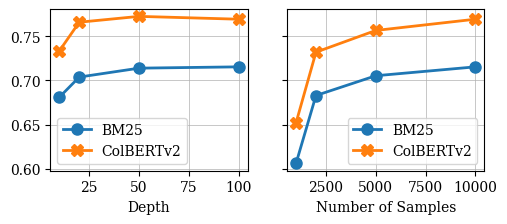

In [15]:
scale = 0.7
fig = plt.figure(figsize=(8 * scale, 3 * scale))
axs = fig.subplots(1, 2, sharey=True)

first_stage_map = {"bm25": "BM25", "colbert": "ColBERTv2"}

for idx, (label, df) in enumerate(zip(["Depth", "Number of Samples"], [depth_table, sample_table])):
    x = df.columns
    ax = axs[idx]
    for first_stage_idx, first_stage in enumerate(df.index):
        y = df.loc[first_stage].values
        first_stage = first_stage_map[first_stage]
        ax.plot(
            x,
            y,
            label=first_stage,
            linewidth=2,
            marker=markers[first_stage_idx],
            markersize=8,
        )
        ax.legend()
    ax.set_xlabel(label)